In [1]:
import warnings

warnings.filterwarnings('ignore')

import os

os.environ['http_proxy'] = 'http://internet.ford.com:83'
os.environ['https_proxy'] = 'http://internet.ford.com:83'

from player_client import PlayerClient
from common_nba import add_game_log_lag, add_game_log_last_5

import nba_constants as c

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import numpy as np
import pandas as pd
import xgboost as xgb

import hyperopt
import glob
import shap

pc = PlayerClient()

Number of players fetched: 4900


In [2]:
season = c.SEASON_2022_2023

path = os.getcwd() + '/data/game_logs'
csv_files = glob.glob(os.path.join(path, '*.csv'))

log = pd.DataFrame()

for f in csv_files:
    df = pd.read_csv(f)
    log = pd.concat([log, df], ignore_index=True)

log.to_csv('./data/2022-23_top_24_players_game_log', index=False)
# log = pc.get_players_game_log(c.RINGER_TOP_30_2023_24, season, 'Ringer_Top_30')
log

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,...,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,OPP_TEAM_ID
0,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201138,2023-03-29,NYK vs. MIA,W,...,2,0,0,0,1,1,3,-3,2022-23,1.610613e+09
1,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201124,2023-03-27,NYK vs. HOU,W,...,1,1,0,0,0,4,26,11,2022-23,1.610613e+09
2,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201093,2023-03-23,NYK @ ORL,L,...,1,0,2,3,4,5,23,20,2022-23,1.610613e+09
3,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201084,2023-03-22,NYK @ MIA,L,...,4,1,0,1,5,1,15,-6,2022-23,1.610613e+09
4,2022-23,203944,Julius Randle,1610612752,NYK,New York Knicks,22201073,2023-03-20,NYK vs. MIN,L,...,4,0,0,0,4,10,57,-6,2022-23,1.610613e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200064,2022-10-26,DEN vs. LAL,W,...,3,4,0,0,3,4,31,28,2022-23,1.610613e+09
1486,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200051,2022-10-24,DEN @ POR,L,...,1,0,0,0,5,4,9,-10,2022-23,1.610613e+09
1487,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200035,2022-10-22,DEN vs. OKC,W,...,3,1,1,0,2,7,19,18,2022-23,1.610613e+09
1488,2022-23,203999,Nikola Jokic,1610612743,DEN,Denver Nuggets,22200026,2022-10-21,DEN @ GSW,W,...,5,0,0,1,4,10,26,-3,2022-23,1.610613e+09


In [3]:
log = add_game_log_lag(log)
log = add_game_log_last_5(log)
log.sort_values(by=[c.GAME_DATE])
log = log[c.PTS_GAME_LOG_MASK]
log.dropna()

log.columns

Index(['PTS', 'MIN_LAG', 'PTS_LAG', 'REB_LAG', 'AST_LAG', 'STL_LAG', 'BLK_LAG',
       'TOV_LAG', 'FG_PCT_LAG', 'FGM_LAG', 'FGA_LAG', 'FG3M_LAG', 'FG3A_LAG',
       'FG3_PCT_LAG', 'FTM_LAG', 'FTA_LAG', 'FT_PCT_LAG', 'PLUS_MINUS_LAG',
       'MIN_LAST_5', 'PTS_LAST_5', 'REB_LAST_5', 'AST_LAST_5', 'STL_LAST_5',
       'BLK_LAST_5', 'TOV_LAST_5', 'FG_PCT_LAST_5', 'FGM_LAST_5', 'FGA_LAST_5',
       'FG3M_LAST_5', 'FG3A_LAST_5', 'FG3_PCT_LAST_5', 'FTM_LAST_5',
       'FTA_LAST_5', 'FT_PCT_LAST_5', 'PLUS_MINUS_LAST_5'],
      dtype='object')

In [4]:
X, y = log.drop(c.PTS, axis=1), log[c.PTS]

cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
    X[col] = X[col].astype('category')

X.dtypes

MIN_LAG              float64
PTS_LAG              float64
REB_LAG              float64
AST_LAG              float64
STL_LAG              float64
BLK_LAG              float64
TOV_LAG              float64
FG_PCT_LAG           float64
FGM_LAG              float64
FGA_LAG              float64
FG3M_LAG             float64
FG3A_LAG             float64
FG3_PCT_LAG          float64
FTM_LAG              float64
FTA_LAG              float64
FT_PCT_LAG           float64
PLUS_MINUS_LAG       float64
MIN_LAST_5           float64
PTS_LAST_5           float64
REB_LAST_5           float64
AST_LAST_5           float64
STL_LAST_5           float64
BLK_LAST_5           float64
TOV_LAST_5           float64
FG_PCT_LAST_5        float64
FGM_LAST_5           float64
FGA_LAST_5           float64
FG3M_LAST_5          float64
FG3A_LAST_5          float64
FG3_PCT_LAST_5       float64
FTM_LAST_5           float64
FTA_LAST_5           float64
FT_PCT_LAST_5        float64
PLUS_MINUS_LAST_5    float64
dtype: object

In [5]:
maes = {
    'baseline': 0,
    'base_model': 0,
    'cross_val': 0,
    'tuned_model': 0
}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print('Baseline MAE: {:.2f}'.format(mae_baseline))
maes['baseline'] = mae_baseline

Baseline MAE: 7.89


In [6]:
params = {'objective': 'reg:squarederror',
          'tree_method': 'hist',
          'eval_metric': 'mae',
          'max_depth': 11,
          'min_child_weight': 7,
          'eta': .3,
          'subsample': 1,
          'colsample_bytree': 1,
          }

n = 1000

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=n,
    evals=[(dtest, "Test")],
    # early_stopping_rounds=10
)

pred = model.predict(dtest)
mae = mean_absolute_error(y_test, pred)
print("Base model MAE: {:.2f}".format(mae))
maes['base_model'] = mae

[0]	Test-mae:7.77603
[1]	Test-mae:7.72365
[2]	Test-mae:7.72739
[3]	Test-mae:7.72611
[4]	Test-mae:7.71451
[5]	Test-mae:7.71062
[6]	Test-mae:7.73261
[7]	Test-mae:7.67604
[8]	Test-mae:7.69352
[9]	Test-mae:7.70039
[10]	Test-mae:7.70318
[11]	Test-mae:7.73237
[12]	Test-mae:7.76053
[13]	Test-mae:7.74731
[14]	Test-mae:7.76978
[15]	Test-mae:7.81336
[16]	Test-mae:7.81581
[17]	Test-mae:7.83867
[18]	Test-mae:7.84945
[19]	Test-mae:7.84996
[20]	Test-mae:7.85487
[21]	Test-mae:7.85321
[22]	Test-mae:7.84678
[23]	Test-mae:7.86210
[24]	Test-mae:7.87420
[25]	Test-mae:7.87191
[26]	Test-mae:7.88198
[27]	Test-mae:7.87780
[28]	Test-mae:7.88578
[29]	Test-mae:7.88214
[30]	Test-mae:7.88688
[31]	Test-mae:7.88711
[32]	Test-mae:7.88271
[33]	Test-mae:7.88747
[34]	Test-mae:7.88837
[35]	Test-mae:7.88553
[36]	Test-mae:7.88530
[37]	Test-mae:7.89323
[38]	Test-mae:7.89976
[39]	Test-mae:7.90335
[40]	Test-mae:7.90238
[41]	Test-mae:7.90395
[42]	Test-mae:7.90664
[43]	Test-mae:7.90886
[44]	Test-mae:7.91070
[45]	Test-mae:7.9073

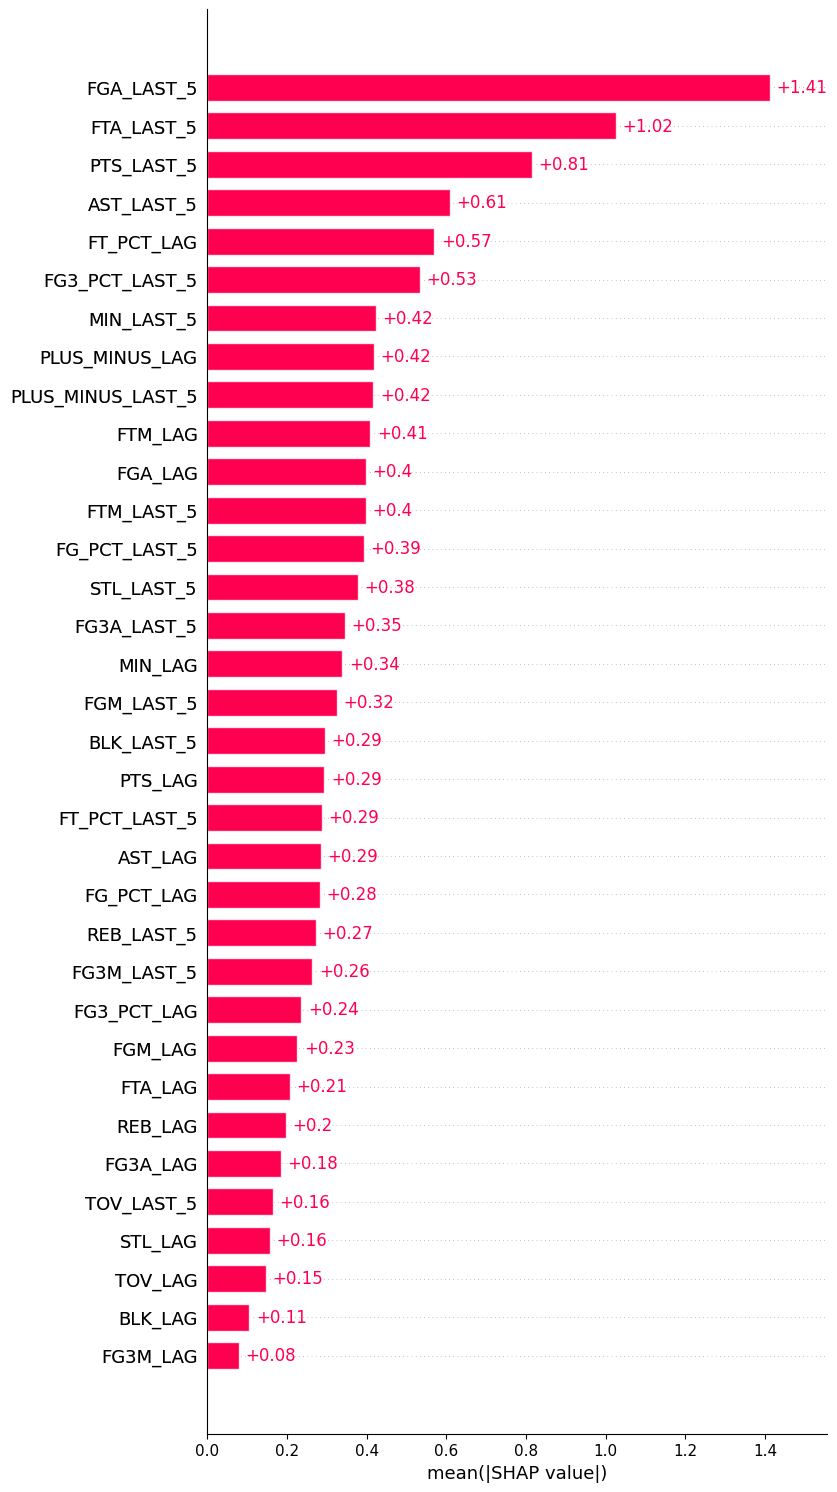

In [7]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=100)
# shap.plots.beeswarm(shap_values, max_display=100)

In [8]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=n,
    seed=42,
    nfold=5,
    metrics=['mae'],
    early_stopping_rounds=10
)
cv_mae = cv_results['test-mae-mean'].min()
print('Cross validation MAE: {mae:.3f}'.format(mae=cv_mae))
maes['cross_val'] = cv_mae

Cross validation MAE: 7.197


In [9]:
def hyperparameter_tuning(space):
    space['max_depth'] = int(space['max_depth'])
    num = int(space['n_estimators'])
    # del space['n_estimators']

    h_model = xgb.train(
        params=space,
        dtrain=dtrain,
        num_boost_round=num,
        # early_stopping_rounds=10
    )

    pred = h_model.predict(dtest)
    mae = mean_absolute_error(y_test, pred)
    print("SCORE:", mae)
    return {'loss': mae, 'status': STATUS_OK, 'model': model}

In [15]:
space = {'objective': 'reg:squarederror',
         'tree_method': 'hist',
         'eval_metric': 'mae',
         'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform('gamma', 1, 9),
         'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
         'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
         }

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=250,
            trials=trials)

print("The best hyperparameters are: ")
print(best)
best['max_depth'] = int(best['max_depth'])


SCORE:                                                 
7.673069488586753                                      
SCORE:                                                                          
8.047066317806294                                                               
SCORE:                                                                          
7.733600892585979                                                               
SCORE:                                                                          
7.948128457363425                                                               
SCORE:                                                                          
7.719702467522097                                                               
SCORE:                                                                          
8.043544094300461                                                               
SCORE:                                                                        

In [16]:
params['max_depth'] = best['max_depth']
params['min_child_weight'] = best['min_child_weight']
params['gamma'] = best['gamma']
params['reg_alpha'] = best['reg_alpha']
params['reg_lambda'] = best['reg_lambda']
params['colsample_bytree'] = best['colsample_bytree']
params['subsample'] = best['subsample']
params['eta'] = best['eta']
n = int(best['n_estimators'])
print(params)
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=n,
    # evals=[(dtest, "Test")],
    # early_stopping_rounds=10
)

pred = model.predict(dtest)
mae = mean_absolute_error(y_test, pred)
print("Tuned model MAE: {:.2f}".format(mae))
maes['tuned_model'] = mae

{'objective': 'reg:squarederror', 'tree_method': 'hist', 'eval_metric': 'mae', 'max_depth': 3, 'min_child_weight': 1.0, 'eta': 0.025, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6420377739814705, 'gamma': 4.4333025302696, 'reg_alpha': 155.0, 'reg_lambda': 0.8935956935724481}
Tuned model MAE: 7.29


In [14]:
maes

{'baseline': 7.893207821601811,
 'base_model': 7.911300308902526,
 'cross_val': 7.197123397038122,
 'tuned_model': 7.275246356831159}

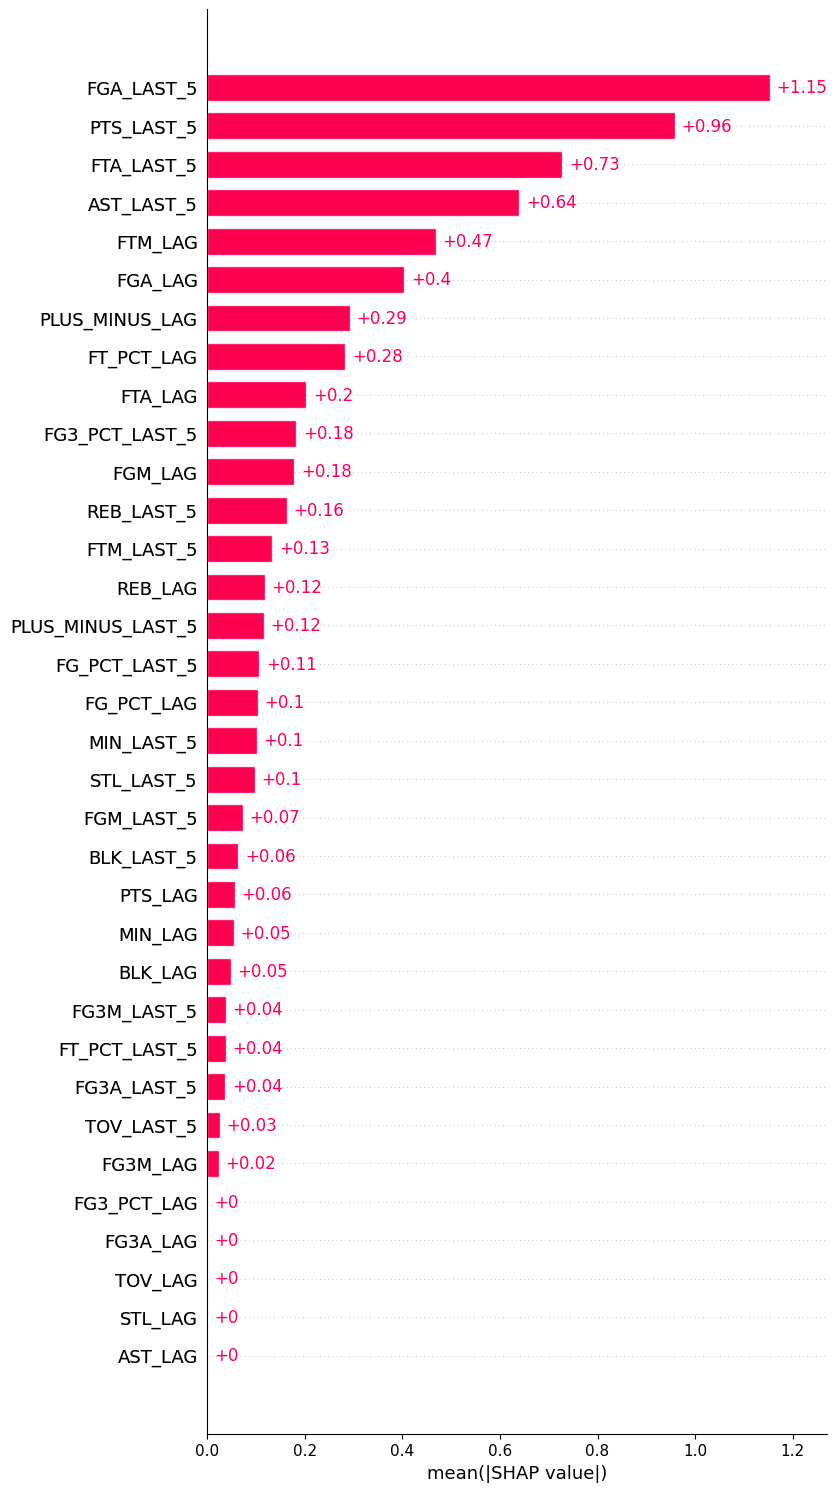

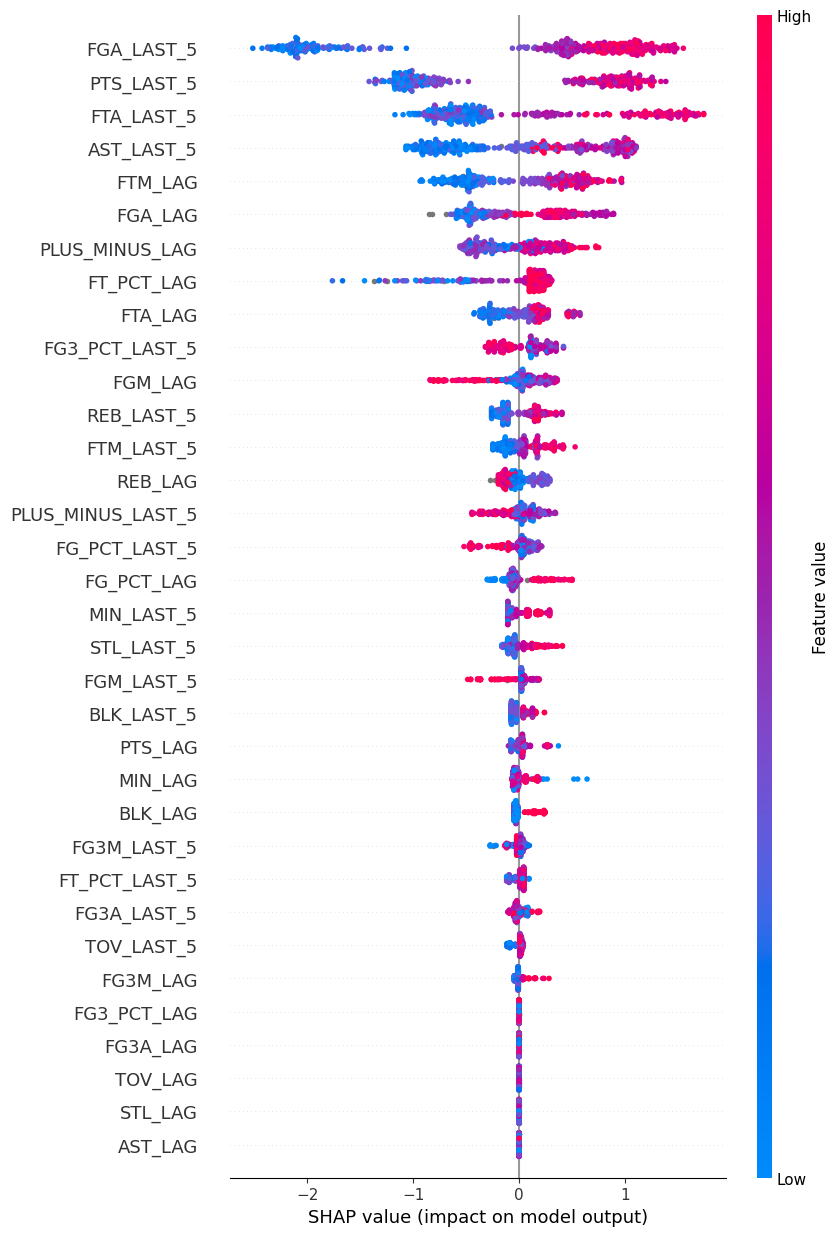

In [13]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, max_display=100)
shap.plots.beeswarm(shap_values, max_display=100)